# Results



In [1]:
# load packages and dependencies

import sys; sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import statsmodels.api as sm

from src.utils import test_stationarity, test_autocorr_specific_lag, test_variance_trend, run_hac_test, variance_ratio_test, run_yearly_tests

In [2]:
# makes the plots readable

plt.rcParams.update({
   'font.size': 12,
   'axes.labelsize': 12,
   'axes.titlesize': 14,
   'xtick.labelsize': 11,
   'ytick.labelsize': 11,
   'legend.fontsize': 11
})

In [3]:
# load price data
df = pd.read_csv('../data/processed/merged_data.csv', index_col=0, parse_dates=True, low_memory=False)

df = df.replace(['empty', 'n/e'], pd.NA)
df = df.apply(pd.to_numeric, errors='coerce')

# load pv data
df_pv = pd.read_csv('../data/external/pv_switzerland.csv', index_col=0)
years = df_pv.index.tolist()


### PV Installations and Capacity in Switzerland (as motivation for Hypothesis 3)

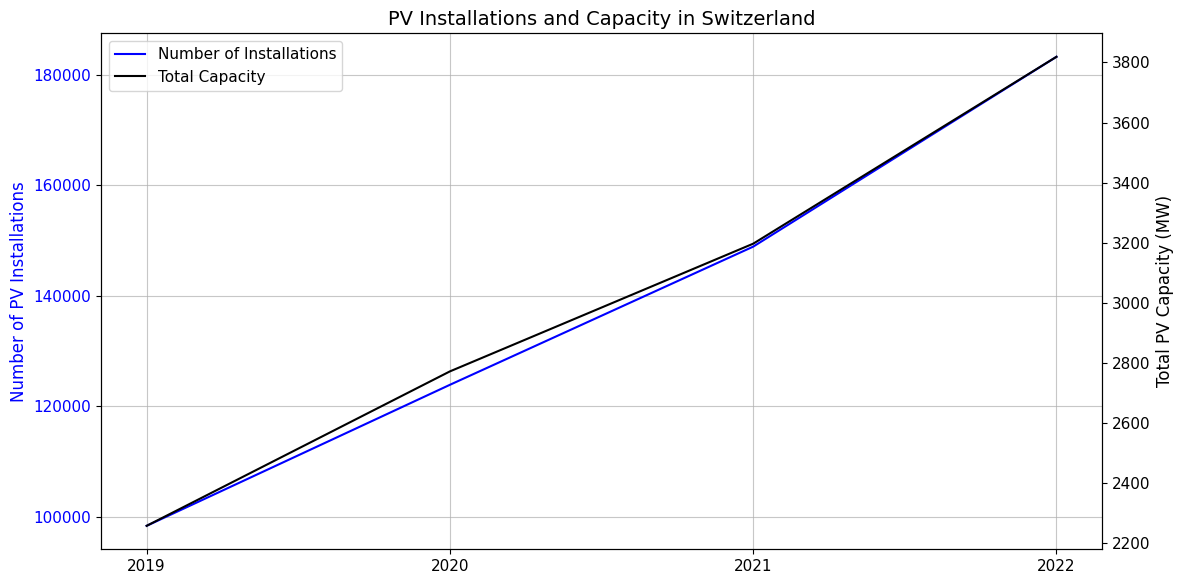

In [4]:
# this plot shows that pv installations and capacity have been increasing over the years in switzerland
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Number of installations
line1 = ax1.plot(years, df_pv['PV-Anlagen (#Anlagen)'].values,
              color='blue',
              label='Number of Installations')
ax1.set_ylabel('Number of PV Installations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Total capacity with fill
line2 = ax2.plot(years, df_pv['PV Leistung (MW)'].values,
              color='black',
              label='Total Capacity')
ax2.set_ylabel('Total PV Capacity (MW)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('PV Installations and Capacity in Switzerland')
plt.xlabel('Year')

# Set x-axis ticks to years only
plt.xticks(years)

# Add major and minor gridlines
ax1.grid(True, which='major', linestyle='-', alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', alpha=0.4)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()

# Save the plot as an SVG file
file_path = "../report/figures/pv_installations_switzerland.png"
plt.savefig(file_path, format='png', dpi=300)

plt.show()

The figure illustrates the growth of solar photovoltaic (PV) installations and capacity in Switzerland from 2019 to 2022:

- **Number of Installations** (blue line, left y-axis): Shows a steady increase in the total number of PV systems installed annually.
- **Total Capacity** (black line, right y-axis): Mirrors the trend in installations, reflecting the increase in the aggregate capacity of PV systems in megawatts (MW).


1. Both the number of installations and total capacity have increased consistently over the years.
2. The linear growth suggests sustained adoption of solar PV technology, likely driven by incentives, decreasing costs, or renewable energy policies.

## Observable Dynamics

The first part of the analysis examines the relationship between auction prices for electricity transport between Switzerland (CH) and Germany (DE). We hypothesize that if the auction price for transporting electricity from CH to DE is positive, the auction price for the reverse direction (DE to CH) should be zero, and vice versa.


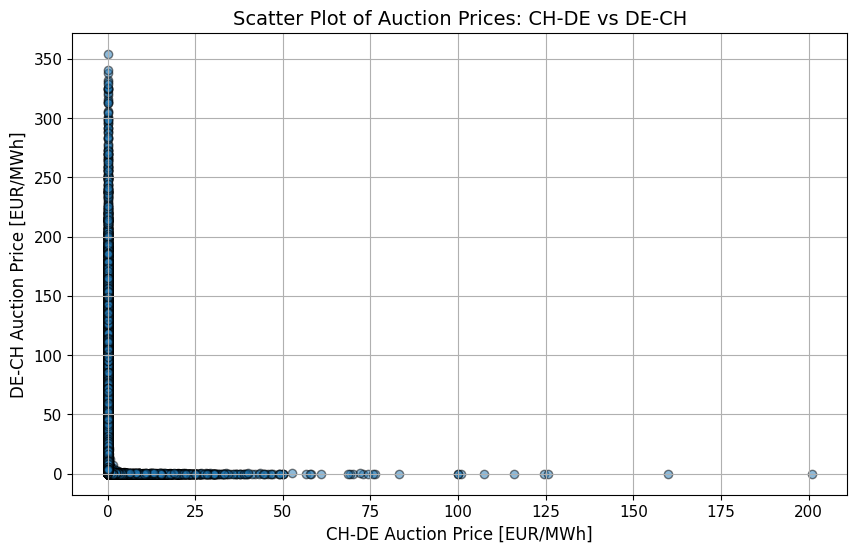

In [5]:
# Drop rows with NA values
df_auction_clean = df.dropna(subset=['ch-de_auctionPrice', 'de-ch_auctionPrice'])

plt.figure(figsize=(10, 6))
plt.scatter(df_auction_clean['ch-de_auctionPrice'], 
          df_auction_clean['de-ch_auctionPrice'], 
          alpha=0.5, 
          edgecolor='k')
plt.xlabel('CH-DE Auction Price [EUR/MWh]')
plt.ylabel('DE-CH Auction Price [EUR/MWh]')
plt.title('Scatter Plot of Auction Prices: CH-DE vs DE-CH')
plt.grid(True)

# Save the plot as an SVG file
file_path = "../report/figures/scatter_plot_ch_de_vs_de_ch_auction_prices.png"
plt.savefig(file_path, format='png', dpi=300)

plt.show()



As we can see in the plot, this is indeed the case. The observations in the mostly on $(0, y)$ with $y \geq0$ or on $(x, 0)$ with $x\geq0$. 

Next, we analyze the weekly averages of the adjusted day-ahead price difference $\delta_t$.


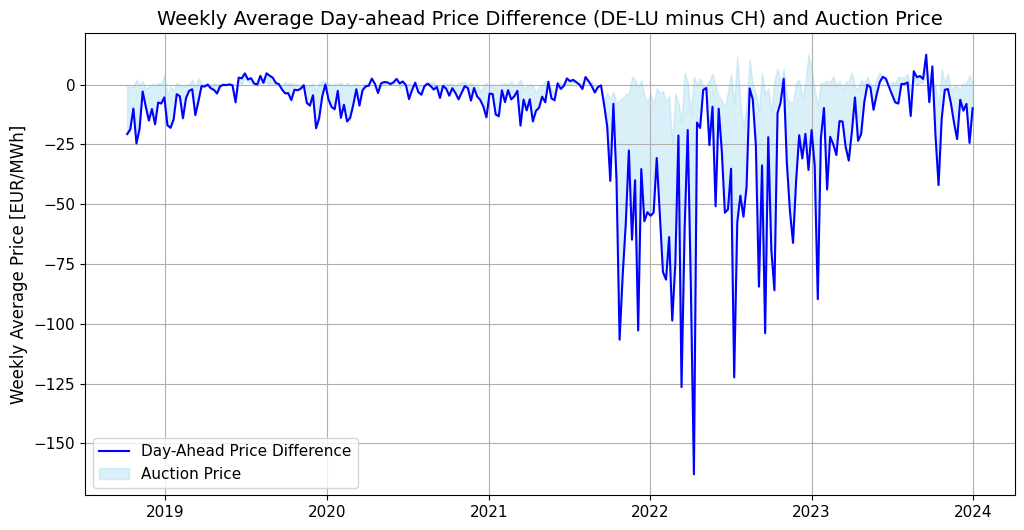

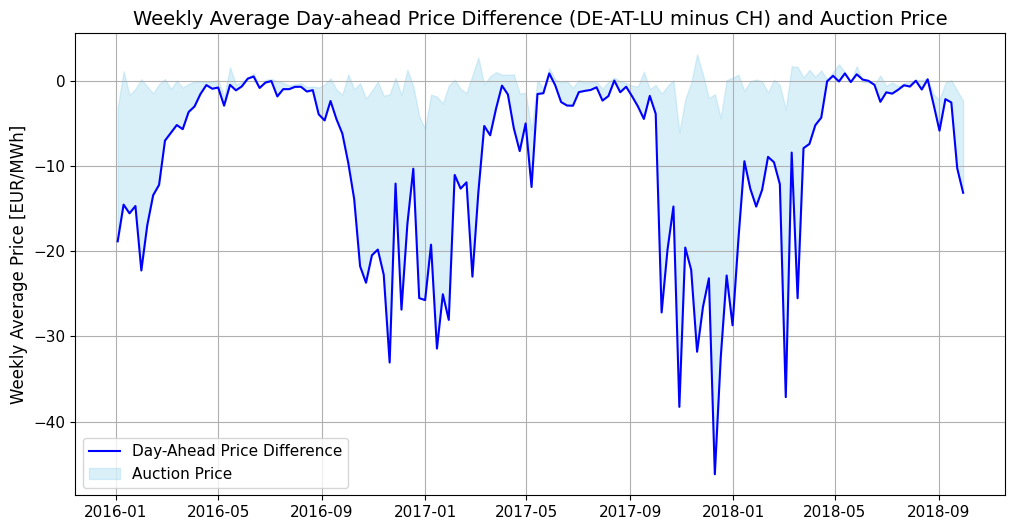

In [6]:
# Calculate Weekly averages for prices and auction data
weekly_df = df.resample('W').mean()

# Calculate price differences 
weekly_df['DE-LU_minus_CH'] = weekly_df['DE-LU'] - weekly_df['CH']
weekly_df['DE-AT-LU_minus_CH'] = weekly_df['DE-AT-LU'] - weekly_df['CH']

plt.figure(figsize=(12, 6))

# Plot DE-LU minus CH price difference
plt.plot(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

# Fill between price difference and auction price
plt.fill_between(
   weekly_df.index,
   weekly_df['DE-LU_minus_CH'],
   weekly_df['DE-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'] - weekly_df['ch-de_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)

# Save the plot as an SVG file
file_path = "../report/figures/weekly_average_day_ahead_price_diff_de-lu_ch.png"
plt.savefig(file_path, format='png', dpi=300)

plt.show()

# Same plot for DE-AT-LU
plt.figure(figsize=(12, 6))
plt.plot(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   label='Day-Ahead Price Difference',
   color='blue'
)

plt.fill_between(
   weekly_df.index,
   weekly_df['DE-AT-LU_minus_CH'],
   weekly_df['DE-AT-LU_minus_CH'] + weekly_df['de-ch_auctionPrice'] - weekly_df['ch-de_auctionPrice'],
   color='skyblue',
   alpha=0.3,
   label='Auction Price'
)

plt.ylabel('Weekly Average Price [EUR/MWh]')
plt.title('Weekly Average Day-ahead Price Difference (DE-AT-LU minus CH) and Auction Price')
plt.legend()
plt.grid(True)

# Save the plot as an SVG file
file_path = "../report/figures/weekly_average_day_ahead_price_diff_de-lu-at_ch.png"
plt.savefig(file_path, format='png', dpi=300)

plt.show()



  - The blue line represents the weekly average day-ahead price difference between Switzerland (CH) and Germany-Luxembourg (DE-LU) and between Switzerland (CH) (plot 1) and Germany-Luxembourg (DE-AT-LU) respectively (plot 2).
  - CH prices are usually higher than DE prices with a clear seasonal pattern. In winter, the difference is larger, whereas in summer, the prices in both day-ahead markets seem to be closer. 
  - The shaded blue area adds the auction price to the day-ahead price difference. Our hypothesis is that the **end of the shaded area should be close to 0**, indicating that auction prices fully account for the day-ahead price differences.

Both plots suggest that auction prices effectively compensate for the difference in day-ahead prices, as the shaded areas align closely with 0 during most periods. Deviations in some periods may reflect temporary inefficiencies or external market factors, but overall, the auction mechanism appears to function as intended.

Also, high price differences are observed during the energy crisis starting winter 2021 to end 2022. Also, observe the different pricing scales (y-axis) between the plots!


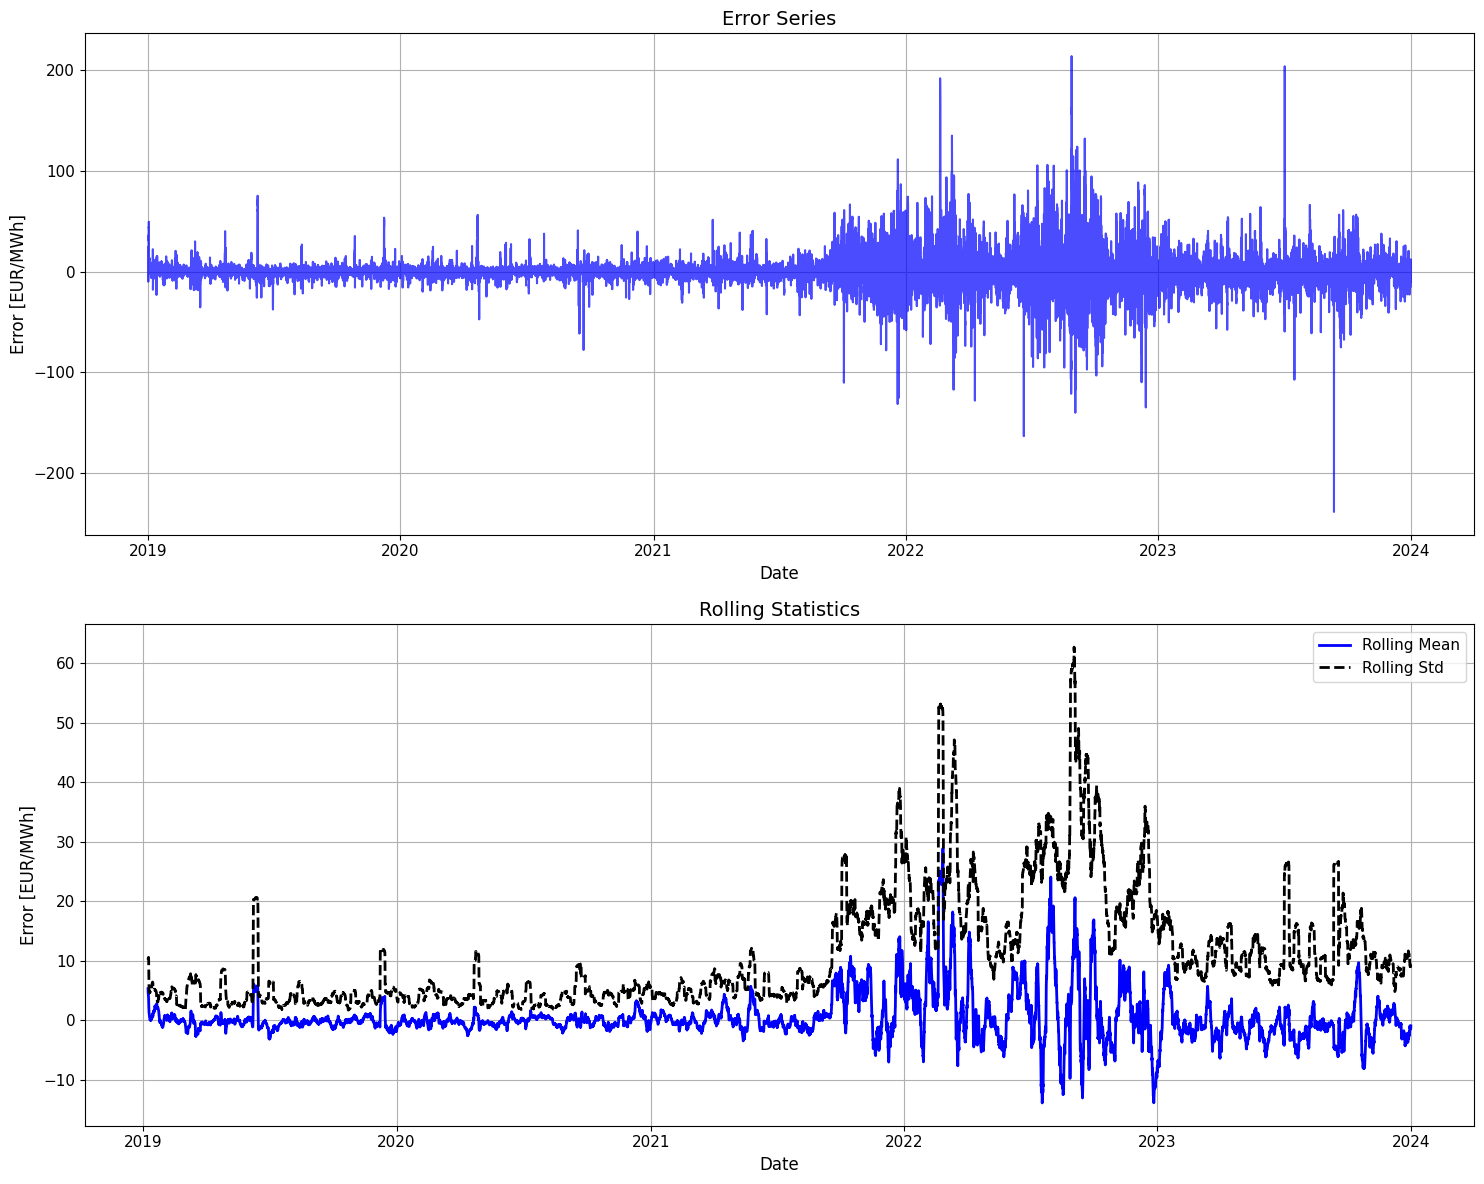

In [7]:
# Handle missing values
# Calculate error series for DE-LU data
df_starting_2019 = df.loc['2019-01-01':].copy()
df_starting_2019['error'] = (df_starting_2019['CH'] - 
                                   df_starting_2019['DE-LU'] - 
                                   df_starting_2019['de-ch_auctionPrice'] +
                                   df_starting_2019['ch-de_auctionPrice'])


error = df_starting_2019['error']
error_clean = error.interpolate()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot error series
ax1.plot(error_clean, color='blue', alpha=0.7)
ax1.set_title('Error Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Error [EUR/MWh]')
ax1.grid(True)


# Plot rolling statistics
window = 24*7  # One week
ax2.plot(error_clean.rolling(window=window).mean(), 
       color='blue', 
       linewidth=2,
       label='Rolling Mean')
ax2.plot(error_clean.rolling(window=window).std(),
       color='black',
       linestyle='--',
       linewidth=2, 
       label='Rolling Std')
ax2.set_title('Rolling Statistics')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error [EUR/MWh]')
ax2.legend()
ax2.grid(True)

# Save the plot as an SVG file
file_path = "../report/figures/error_series.png"
plt.savefig(file_path, format='png', dpi=300)

plt.tight_layout()
plt.show()

Hourly error series (top plot) and rolling statistics (bottom plot). The error series illustrates deviations between auction prices and day-ahead price differences, while the rolling mean and standard deviation capture trends in central tendency and variability.

- The error term $\delta_t$, depicted in the top plot, remains mostly centered around zero throughout the observation period, suggesting a mean-reverting process consistent with efficient market behavior.
- Starting in 2022, significant spikes and dips in the error term emerge, highlighting periods of increased volatility.
- The rolling mean consistently hovers near zero, reinforcing the absence of a persistent trend in the error term over the observed period.
- The rolling standard deviation exhibits a sharp increase during 2022 and 2023, indicating a notable rise in volatility in $\delta_t$.


In [8]:
# 1. Test stationarity (ADF test)
stationarity_results = test_stationarity(df_starting_2019['error'])

# HAC test using results.t_stat() instead of deprecated tvalues[0]
hac_results = run_hac_test(df_starting_2019['error'])

# 3. Test autocorrelation at lag 24
autocorr_results = test_autocorr_specific_lag(df_starting_2019['error'], 24)

# 4. Test if normalized variance is increasing over time
variance_trend_results = test_variance_trend(
   df_starting_2019['CH'],
   df_starting_2019['DE-LU'], 
   df_starting_2019['error']
)

variance_ratio_test_results = variance_ratio_test(
   df_starting_2019['CH'],
   df_starting_2019['DE-LU'], 
   df_starting_2019['error']
)

# Print results
print("Stationarity Test:")
print(f"ADF Statistic: {stationarity_results['adf_stat']:.4f}")
print(f"P-value: {stationarity_results['p_value']:.4f}")

print("\nHAC Test:")
print(f"T-test: {hac_results['t_stat']:.4f}")
print(f"P-value: {hac_results['p_value']:.4f}")

print("\nAutocorrelation Test (Lag 24):")
print(f"ACF: {autocorr_results['acf']:.4f}")
print(f"Z-statistic: {autocorr_results['z_stat']:.4f}")
print(f"P-value: {autocorr_results['p_value']:.4f}")

print("\nVariance Trend Test:")
print(f"Slope: {variance_trend_results['slope']:.4e}")
print(f"P-value: {variance_trend_results['p_value']:.4f}")
print(f"R-squared: {variance_trend_results['r_squared']:.4f}")

print("\nVariance Ratio Test:")
print(f"Variance Ratio: {variance_ratio_test_results['variance_ratio']:.4f}")
print(f"F-statistic: {variance_ratio_test_results['f_statistic']:.4f}")
print(f"P-value: {variance_ratio_test_results['p_value']:.4f}")
print(f"Degrees of Freedom (df1): {variance_ratio_test_results['df1']}")
print(f"Degrees of Freedom (df2): {variance_ratio_test_results['df2']}")


Stationarity Test:
ADF Statistic: -26.1123
P-value: 0.0000

HAC Test:
T-test: 2.1746
P-value: 0.0297

Autocorrelation Test (Lag 24):
ACF: 0.0206
Z-statistic: 4.3068
P-value: 0.0000

Variance Trend Test:
Slope: 1.0046e-05
P-value: 0.9585
R-squared: 0.0000

Variance Ratio Test:
Variance Ratio: 2.6850
F-statistic: 2.6850
P-value: 0.0000
Degrees of Freedom (df1): 21911
Degrees of Freedom (df2): 21911


### Statistical Results Interpretation

Stationarity Test (ADF)
- The Augmented Dickey-Fuller (ADF) test strongly indicates that the series is stationary, as the null hypothesis of a unit root is rejected with a highly significant p-value. This confirms that the series' statistical properties (mean, variance, and autocorrelation) are constant over time, making it suitable for time-series analysis.
- The HAC test result suggests that deviations between auction prices and implied price spreads are not purely random. A statistically significant t-statistic and p-value indicate potential structural inefficiencies or systematic biases in the market influencing these deviations.
- The autocorrelation at lag 24 is low but statistically significant. This reveals weak yet persistent patterns in the deviations, where past deviations have a slight influence on future ones, potentially hinting at recurring market behaviors.
- The variance trend test shows no significant trend in the variability of deviations over time. This suggests that market inefficiencies have neither increased nor decreased systematically during the observation period.
- The significant variance ratio indicates mean-reverting behavior in the deviations, with short-term variability exceeding long-term variability. This supports the notion that deviations are temporary and self-correcting over time.

### Implications
- The series is stationary and deviations are mean-reverting, confirming stability over time.
- Significant autocorrelation and HAC test results suggest that deviations are not entirely random but exhibit weak, predictable patterns. This implies that past deviations may provide some predictive power for future deviations.
- The lack of a variance trend confirms stable inefficiencies over time. The variance ratio test could just be the results of the stress phase during 2021, 2022. 

In [9]:
table = run_yearly_tests(df_starting_2019, range(2019, 2024))
print("\nStatistical Tests Results by Year:")
print(table)


Statistical Tests Results by Year:
      ADF Statistic  ADF p-value  HAC t-stat  HAC p-value  Autocorr(24)  \
Year                                                                      
2019       -17.4701          0.0     -0.2946       0.7683       -0.0475   
2020       -21.3443          0.0     -1.1170       0.2640        0.0322   
2021       -13.7738          0.0      2.9032       0.0037        0.0260   
2022       -13.3621          0.0      2.5573       0.0106        0.0159   
2023       -15.7985          0.0     -2.3408       0.0192        0.0166   

      Autocorr p-value  
Year                    
2019            0.0000  
2020            0.0026  
2021            0.0149  
2022            0.1378  
2023            0.1213  



- The ADF test consistently indicates that the error term $\delta_t$ is stationary across all years, as evidenced by highly negative ADF statistics and p-values close to zero. This result supports the convergence hypothesis, implying that deviations in cross-border electricity pricing are mean-reverting regardless of the year. Even during volatile periods, such as 2022, the stationarity of the error term suggests that the market mechanism retains its ability to correct pricing discrepancies over time.
- The HAC-adjusted t-test reveals considerable variation in the statistical significance of the mean error term across years. For example:
    - In **2019** and **2020**, the mean deviations are not statistically significant, with p-values well above $0.05$. These findings indicate that, under normal market conditions, the mean pricing error is negligible.
    - In **2021**, **2022**, and **2023**, the t-statistics indicate significant deviations from zero, suggesting potential inefficiencies. The results for 2021 and 2022 align with the increased market volatility during the energy crisis, highlighting periods of stress in the cross-border electricity market.
- The autocorrelation coefficient at lag 24 shows varying significance across years:
    - In **2019** and **2020**, significant autocorrelation is observed ($p = 0.000$ and $p = 0.003$), indicating systematic dependencies in pricing errors over daily cycles. These dependencies may reflect structural inefficiencies or recurring forecast errors during these years.
    - From **2021** onward, the autocorrelation becomes less significant, with p-values of $0.015$ in 2021 and above $0.1$ in 2022 and 2023. This reduction in significance suggests that, despite heightened volatility in 2022, pricing errors exhibit fewer systematic patterns, possibly due to improved forecasting or market adjustments.